In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from datetime import datetime, timedelta, date
from collections import OrderedDict
import subprocess
import fuzzywuzzy
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

In [3]:
freqdata = frequency.information(data,period_format="year")
freqdata = frequency.distribution(freqdata,metadata_selectors=["speech_member_party"])
freqdata = frequency.normalization(freqdata,'/media/ruben/Elements/PhD/data/hansard/resources/character_counts_year_pm.csv')
freqdata = freqdata[freqdata['speech_member_party'].isin(['Conservative','Labour'])].reset_index(drop=True)

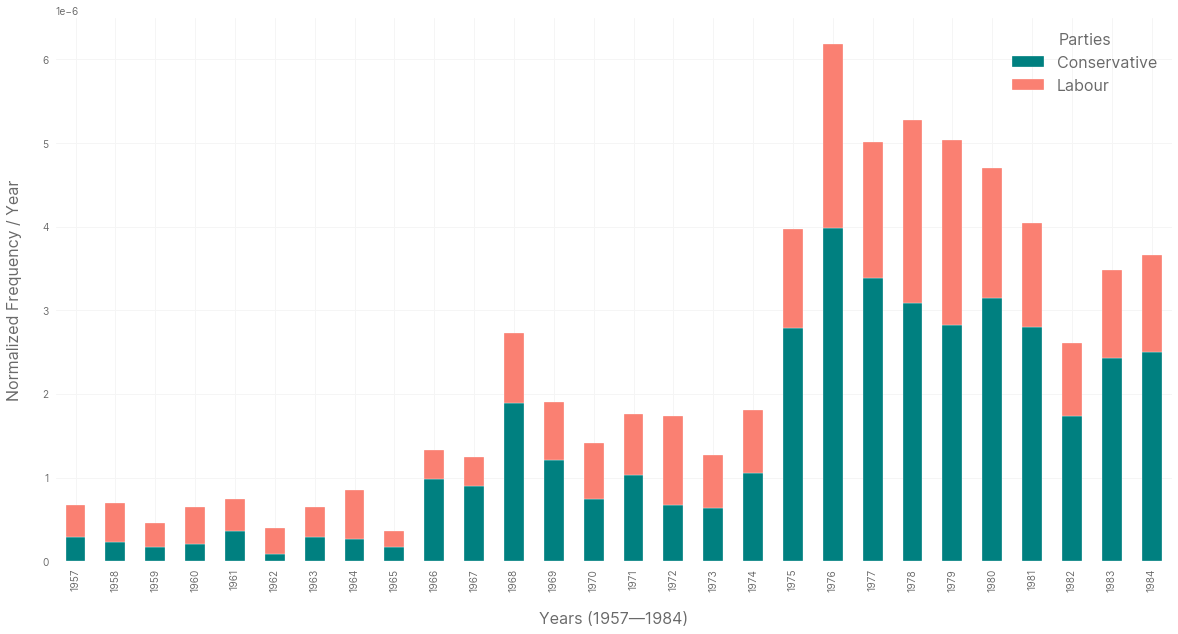

In [73]:
# Plot Relative Frequency per Party, stacked
plotting.style(var_length=20)
freqdata_ = freqdata.pivot(index='date',columns='speech_member_party',values='bureaucracy_hits').reset_index().fillna(0.0)

fig, ax = plt.subplots()
freqdata_.plot.bar(x='date',y=list(freqdata_.columns)[1:],figsize=(20,10),stacked=True,color=['teal','salmon'],ax=plt.gca())
plt.xlabel("Years (1957—1984)",labelpad=20)
plt.ylabel("Normalized Frequency / Year",labelpad=20)
ax.legend(title="Parties",fontsize=16)
plt.savefig("/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/freq-bureaucracy-rel-bar-party.png",dpi=450)
plt.show()

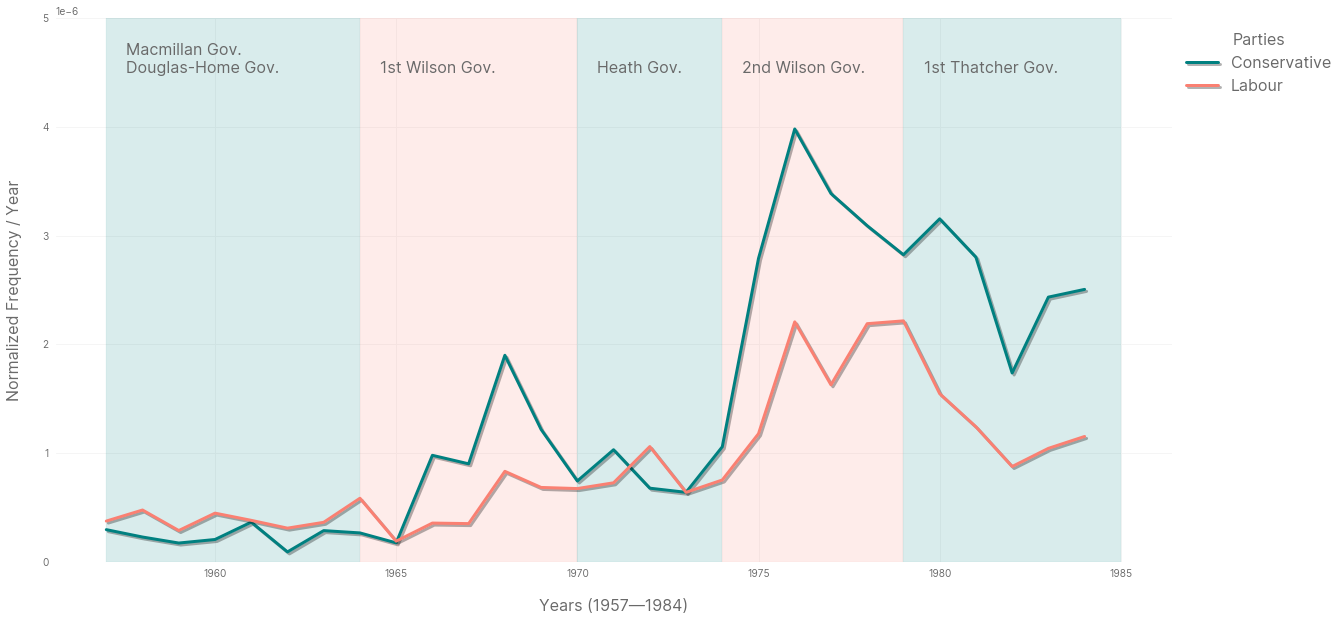

In [83]:
# freqdata_['Total'] = freqdata_['Conservative'] + freqdata_['Labour']
# freqdata_['Conservative'] = freqdata_['Conservative'] / freqdata_['Total']
# freqdata_['Labour'] = freqdata_['Labour'] / freqdata_['Total']
# freqdata_ = freqdata_.drop('Total',axis=1)

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(freqdata_['date'], freqdata_['Conservative'],color='teal',linewidth=3,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])
plt.plot(freqdata_['date'], freqdata_['Labour'],color='salmon',linewidth=3,path_effects=[path_effects.SimpleLineShadow(),path_effects.Normal()])

freqdata_['date'] = freqdata_['date'].astype(int)
plt.xlabel("Years (1957—1984)",labelpad=20)
plt.ylabel("Normalized Frequency / Year",labelpad=20)
ax.legend(labels=['Conservative','Labour'], title="Parties",fontsize=16,bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(0,0.000005)
for x in [['Macmillan Gov. \nDouglas-Home Gov.',1957,1964,"teal"],["1st Wilson Gov.",1964,1970,"salmon"],["Heath Gov.",1970,1974,"teal"],["2nd Wilson Gov.",1974,1979,"salmon"],["1st Thatcher Gov.",1979,1985,"teal"]]:
    ax.axvspan(x[1], x[2], alpha=0.15, color=x[3])
    ax.text(x[1] + (abs(ax.get_xlim()[0]-ax.get_xlim()[1]) / 55),ax.get_ylim()[1] - (abs(ax.get_ylim()[0]-ax.get_ylim()[1]) / 10), x[0], fontsize=16)

plt.savefig("/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/freq-bureaucracy-annotated-line-party.png",dpi=450)
plt.show()

In [21]:
### Pointwise Mutual Information for identifying related terms

pmi_data = pd.DataFrame()
list_bins = [[x,x+3] for x in range(1957,1985)]

for c,bin in enumerate(list_bins):
    data = data_loader.subset(data_version="lemmatized_pm",start_date=bin[0],end_date=bin[1],words=[],preprocess=True)
    pmi_df = frequency.get_pmi_table(data,"|".join([str(x) for x in range(bin[0],bin[1])]),12,'bureaucracy',text_column="text_lemmatized")
    pmi_df['period'] = "-".join([str(x) for x in list_bins[c]])
    pmi_data = pmi_data.append(pmi_df)

egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1957*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1958*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1959*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1958*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1959*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1960*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1959*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1960*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1961*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1960*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1961*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1962*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard/lemmatized_pm/*1961*
egrep -iE '' /media/ruben/Elements/PhD/data/hansard

In [22]:
d = pd.DataFrame()
for y in sorted(list(set(pmi_data['period']))):
    t = list(pmi_data[pmi_data['period'] == y].sort_values('npmi')['w'][1:50])
    d[y] = t

In [23]:
pmi_data.to_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/pmi-table-s3-w12-1957-1985.csv',index=False)

In [24]:
d.to_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/pmi-topwords-s12-w8-1957-1985.csv',index=False)

In [2]:
## Import annotated data
annotations = pd.read_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/data/classifier/annotated-arguments-bureaucracy.csv')
annotations = annotations[["id","label","text"]]
annotations['metadata'] = ''

refdata = pd.read_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/data/classifier/training_data_full.csv',sep='\t')
refdata['id-ann'] = [x + 594 for x in refdata.index]

for c,i in enumerate(annotations['id']):
    annotations['metadata'][c] = str(refdata[refdata['id-ann'] == i].reset_index(drop=True)['id'][0])


stops = stopwords.words('english') + ["hon","member","right","friend","mr",'hon.','make','say','great']
annotations['text'] = utils.preprocess_(annotations['text'])
annotations = annotations.drop('id',axis=1).reset_index(drop=True)

labels = {1:"neutral",2:"inefficient",3:"powerful/large",4:"centralization",5:"freedom",6:"expensive",7:"anti-democratic"}
annotations['label'] = annotations['label'].astype(str)

In [5]:
annotations['label'] = [labels[int(x)] for x in annotations['label']]

In [6]:
tfidfo, docterms = tfidf.get_docterms(annotations,"text")
tt = tfidf.get_topterms(tfidfo,docterms,annotations,'label')

In [7]:
tt

,expensive,freedom,inefficient,centralization,powerful/large,neutral,anti-democratic
0,cost,freedom,government,industry,hon,hon,democratic
1,government,citizen,hon,nationalisation,government,make,parliament
2,million,people,member,state,local,government,elect
3,money,individual,board,policy,say,member,member
4,service,local,great,government,people,say,democracy
5,hon,house,local,nationalise,friend,friend,executive
6,time,member,small,economic,service,people,people
7,expensive,authority,make,enterprise,hon friend,right,say
8,great,hon,minister,wish,right,hon friend,public
9,know,government,say,hon,member,house,decision
